In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, chi2_contingency, spearmanr
import struct
from codecs import decode

In [2]:
df = pd.read_csv('Data/house_price_Dống-Da_Hà-Nội_subdata.csv')
df.head()

,area,price,postDate,land_certificate,house_direction,balcony_direction,toilet,bedroom,floor,lat,long,property_type
0,50.0,14700.0,44197,So do,NaN,NaN,4.0,6.0,6.0,21.015698,105.824583,trong ngo
1,57.0,4200.0,44265,So do,Nam,Nam,3.0,8.0,4.0,21.025208,105.833111,trong ngo
2,62.0,11000.0,44268,So do,NaN,dong-Nam,6.0,5.0,6.0,21.025379,105.801011,trong ngo
3,26.0,2900.0,44292,So do,NaN,NaN,4.0,3.0,4.0,21.014325,105.834918,trong ngo
4,40.0,3950.0,44292,So do,NaN,NaN,NaN,NaN,5.0,21.009862,105.838083,trong ngo


In [3]:
df = df[(df['area'] > 0) & (df['price'] > 0)]
df['price/m2'] = df['price'] / df['area']
df.describe()

,area,price,postDate,toilet,bedroom,floor,lat,long,price/m2
count,600.000000,6.000000e+02,600.000000,237.000000,316.000000,357.000000,600.000000,600.000000,600.000000
mean,112.264583,2.961441e+04,44265.561667,3.632911,4.322785,4.753501,21.015420,105.825257,221.522396
std,495.846912,1.484516e+05,57.529752,2.358777,2.594913,1.687951,0.006677,0.009205,385.254899
min,14.000000,4.500000e+00,44197.000000,1.000000,1.000000,1.000000,20.998499,105.795544,0.122500
25%,41.000000,4.200000e+03,44197.000000,2.000000,3.000000,4.000000,21.009739,105.821315,100.000000
50%,55.000000,9.250000e+03,44306.000000,4.000000,4.000000,5.000000,21.017288,105.828030,169.090909
75%,85.000000,2.192500e+04,44312.000000,4.000000,6.000000,5.000000,21.019019,105.829949,283.149510
max,11000.000000,3.300000e+06,44325.000000,16.000000,22.000000,11.000000,21.036845,105.841407,8333.333333


## 1. Giữa giá nhà và diện tích có tương quan với nhau?

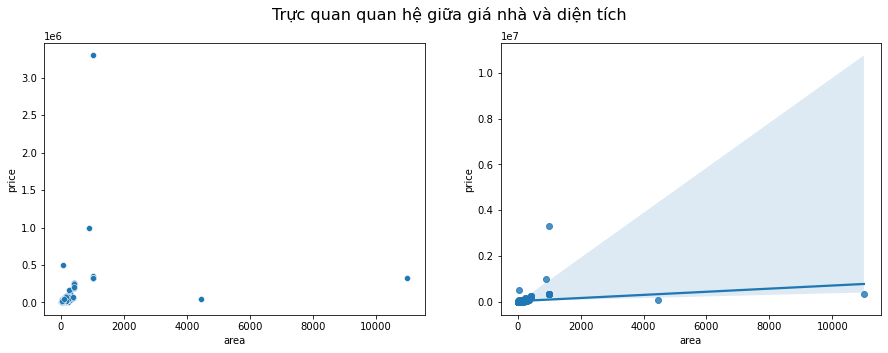

In [4]:
fig, axs = plt.subplots(1,2,figsize = (15,5))
sns.scatterplot(y = 'price', x = 'area', data = df, ax=axs[0])
sns.regplot(y = 'price', x = 'area', data = df, ax=axs[1])
plt.suptitle('Trực quan quan hệ giữa giá nhà và diện tích', fontsize =16)
plt.show()

### Phát biểu giả thuyết :
- H0 : Giá nhà và diện tích không có mối quan hệ với nhau
- H1 : Gía nhà và diện tích có mối quan hệ với nhau

In [5]:
r, pvalue = pearsonr(x = df['price'], y = df['area'])
print(f'Hệ số tương quan Pearson: {r}')
print(f'p-value: {pvalue}')

Hệ số tương quan Pearson: 0.22777496323564306
p-value: 1.680683605165334e-08


### Kết luận : pvalue < 0.05
- Bác bỏ H0
- Vậy với độ tin cậy 95% thì giữa giá nhà và diện tích có mối quan hệ tuyến tính yếu

## 2. Giữa giá nhà và tọa độ địa lý (lat, long) có tương quan với nhau

In [6]:
# xóa những điểm trùng tọa độ địa lý(lat,long)
df2 = df.drop_duplicates(subset=['lat','long'], keep = 'first')

### mã hóa located :
- Chuyển lat, long về dạng 32 bit
- Ghép thành 64 bit từ lat, long theo đúng thứ tự rồi chuyển sang float pointing

In [49]:
def float_to_bin_4bytes(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))

def int_to_bytes(n, length):  # Helper function
    return decode('%%0%dx' % (length << 1) % n, 'hex')[-length:]

def bin_to_float(b):
    bf = int_to_bytes(int(b, 2), 8)
    return struct.unpack('>d', bf)[0]

def float_to_bin_8bytes(value):  # For testing.
    [d] = struct.unpack(">Q", struct.pack(">d", value))
    return '{:064b}'.format(d)

In [50]:
# chuẩn hóa 
df2['located'] = df2['lat'].apply(float_to_bin_4bytes) + df2['long'].apply(float_to_bin_4bytes)
df2['located'] = df2['located'].apply(bin_to_float)

/tmp/ipykernel_7026/3065001232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['located'] = df2['lat'].apply(float_to_bin_4bytes) + df2['long'].apply(float_to_bin_4bytes)


In [14]:
df2.head()

,area,price,postDate,land_certificate,house_direction,balcony_direction,toilet,bedroom,floor,lat,long,property_type,price/m2,located
0,50.0,14700.0,44197,So do,NaN,NaN,4.0,6.0,6.0,21.015698,105.824583,trong ngo,294.000000,0100000110101000001000000010011001000010110100...
1,57.0,4200.0,44265,So do,Nam,Nam,3.0,8.0,4.0,21.025208,105.833111,trong ngo,73.684211,0100000110101000001100111010000001000010110100...
2,62.0,11000.0,44268,So do,NaN,dong-Nam,6.0,5.0,6.0,21.025379,105.801011,trong ngo,177.419355,0100000110101000001100111111101001000010110100...
3,26.0,2900.0,44292,So do,NaN,NaN,4.0,3.0,4.0,21.014325,105.834918,trong ngo,111.538462,0100000110101000000111010101011001000010110100...
4,40.0,3950.0,44292,So do,NaN,NaN,NaN,NaN,5.0,21.009862,105.838083,trong ngo,98.750000,0100000110101000000101000011001101000010110100...


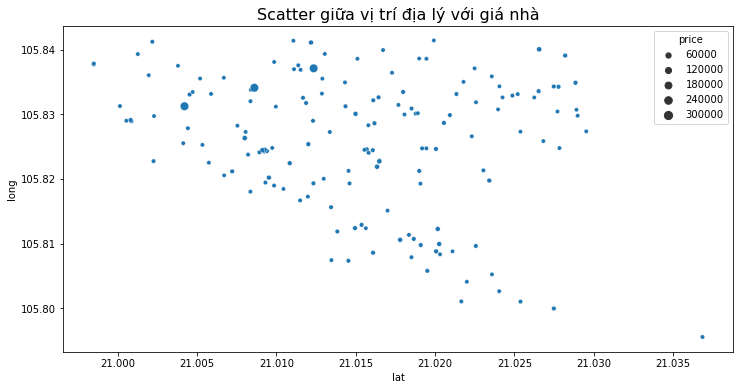

In [7]:
plt.rcParams['figure.figsize'] = (12,6)
sns.scatterplot(x = 'lat', y = 'long' , size ='price', data = df2)
plt.title('Scatter giữa vị trí địa lý với giá nhà', fontsize = 16)
plt.show()

In [9]:
r, pvalue = pearsonr(x = df2['price'], y = df2['located'])
print(f'Hệ số tương quan Pearson: {r}')
print(f'p-value: {pvalue}')

Hệ số tương quan Pearson: -0.0919143657429455
p-value: 0.25848125464747096


### Kết luận : pvalue > 0.05
- Chưa đủ cơ sở bác bỏ H0
- Vậy với độ tin cậy 95% thì giữa giá nhà và tọa độ địa lý không có mối tương quan lẫn nhau.

## 3. Giữa thuộc tính land_certificate và property_type có tương quan với nhau

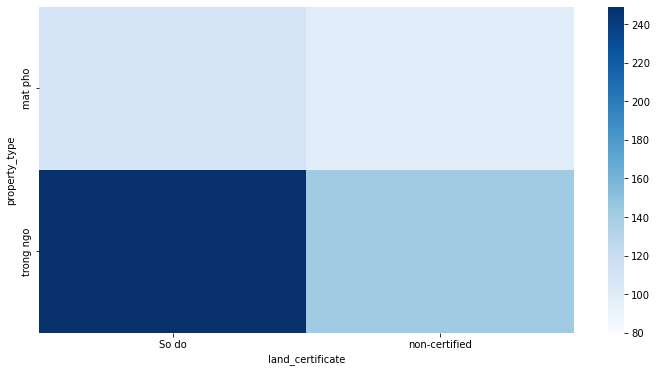

In [10]:
crosstable = pd.crosstab(index = df['property_type'] , columns = df['land_certificate'].fillna('non-certified'))
sns.heatmap(crosstable, cmap='Blues', vmin = 80)
plt.show()

In [11]:
chi2, pvalue, dof, expected = chi2_contingency(crosstable)
print(f'Hệ số Chi-Square: {chi2}')
print(f'p-value: {pvalue}')

Hệ số Chi-Square: 6.469112327700184
p-value: 0.010976534479430937


### Kết luận : pvalue < 0.05
- Bác bỏ H0
- Với độ tin cậy 95% thì giữa giữa land_certificate và property_type có mối quan hệ tuyến tính với nhau

## 4. Hãy  mã hóa lại thuộc tính giá nhà theo đơn vị (nghìn đồng/m2) và sắp xếp giá nhà thành bốn mức tương ứng với các khoảng tứ phân vị. Tiến hành kiểm định tương quan giữa biến giá nhà này với các biến tọa độ vị trí (lat, long)

In [12]:
q1 = df2['price/m2'].quantile(q = 0.25)
q2 = df2['price/m2'].quantile(q = 0.50)
q3 = df2['price/m2'].quantile(q = 0.75)
list_condition = [df2['price/m2'] < q1, 
                 (df2['price/m2'] >= q1) & (df2['price/m2'] < q2),
                 (df2['price/m2'] >= q2) & (df2['price/m2'] < q3),
                  df2['price/m2'] >= q3]
list_choice = [1,2,3,4]
df2['price/m2_oridinal'] = np.select(condlist = list_condition, choicelist = list_choice)

/tmp/ipykernel_15976/3458498863.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['price/m2_oridinal'] = np.select(condlist = list_condition, choicelist = list_choice)


### Phát biểu giả thuyết :
- H0 : price/m2_oridinal và located không có quan hệ
- H1 : price/m2_oridinal và located có quan hệ với nhau.

In [17]:
corr, pvalue = spearmanr(a = df2['price/m2_oridinal'], b = df2['located'])
print(f'Hệ số tương quan hạng Spearman: {corr}')
print(f'p-value: {pvalue}')

Hệ số tương quan hạng Spearman: 0.018456463209128807
p-value: 0.82085849289369


### Kết luận : pvalue > 0.05
- Chưa đủ cơ sở bác bỏ H0
- Vậy với độ tin cậy 95% thì price/m2_oridinal và located không có quan hệ tuyến tính với nhau.